In [1]:
import torch
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt
#import utils
import models
#import model
from torchsummary import summary
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pdb
import albumentations as A
import DataAugmentations as Aug
import torch.nn as nn

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata_path = '/Users/mouzam/TSAI/data/cifar-10-batches-py/batches.meta' 
metadata = unpickle(metadata_path)

inttoclasses = {i:classes for  i,classes in  enumerate(metadata[b'label_names'])}

In [3]:
#Mean Train
print(Aug.train_data.data.mean(axis=(0, 1, 2))/255)
#Mean Test
print(Aug.test_data.data.mean(axis=(0, 1, 2))/255)

[0.49139968 0.48215841 0.44653091]
[0.49421428 0.48513139 0.45040909]


In [4]:
#Std Train
print(Aug.train_data.data.std(axis=(0, 1, 2))/255)
#Std test
print(Aug.test_data.data.std(axis=(0, 1, 2))/255)

[0.24703223 0.24348513 0.26158784]
[0.24665252 0.24289226 0.26159238]


In [5]:
training_iterator = iter(Aug.train_loader)

In [6]:
batch_images, batch_labels = next(training_iterator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

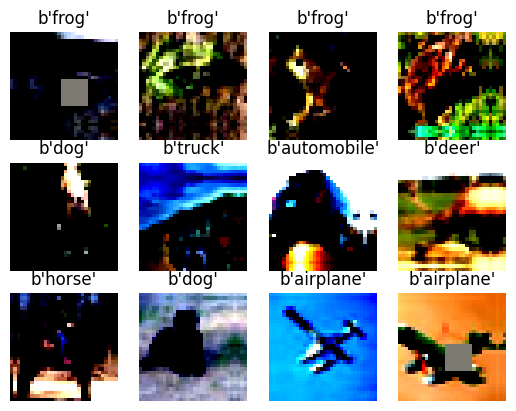

In [7]:

# Print 12 images to see the sample data
for i in range(12):
    plt.subplot(3,4,i+1)
    im = batch_images[i]
    im = np.transpose(im, axes=[1, 2, 0])
    plt.imshow(im)
    plt.title(inttoclasses[batch_labels[i].item()])
    plt.axis('off')

In [2]:

has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

In [3]:
def get_lr(optimizer):
    """"
    for tracking how your learning rate is changing throughout training
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [4]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []

def train(model, device, train_loader, optimizer, scheduler,criterion):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
 
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    #print('Printing batch id -->' + str(batch_idx))
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #pdb.set_trace()
    #loss = F.nll_loss(y_pred, target)
    loss = criterion(y_pred, target)
    train_losses.append(loss)
    lrs.append(get_lr(optimizer))
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    scheduler.step()
    # Update pbar-tqdm
    #pdb.set_trace()
    _, pred = torch.max(y_pred.data, 1)
    #pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    #print(lr)
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += criterion(output, target).item()
            _, pred = torch.max(output.data, 1)
            #pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    #pdb.set_trace()
    # misclassified_images = data[(pred != target.view_as(pred)).view(-1)]
    # misclassified_images_actual_label = target[(pred != target.view_as(pred)).view(-1)]
    # misclassified_images_predicted_label = pred[(pred != target.view_as(pred)).view(-1)].squeeze(1)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # test_acc.append(100. * correct / len(test_loader.dataset))

    return test_loss


In [5]:
device

'mps'

In [6]:
model = models.model().to(device= device)

#model = model.CustomResNet().to(device)

/Users/mouzam/TSAI/.venv/lib/python3.11/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
 64%|██████▍   | 128/200 [01:13<00:41,  1.73it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.74E-02


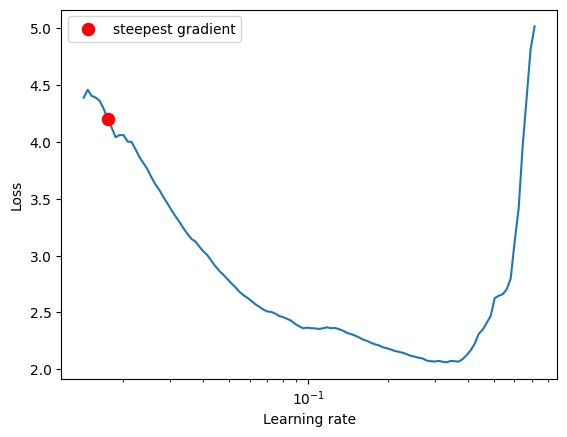

In [7]:
from torch_lr_finder import LRFinder

# #model = CustomResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.01, weight_decay= 1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(Aug.train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [8]:

#optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
#step_sizes = 8  # Adjust the learning rate after 10, 20, and 30 epochs
gamma = 0.1  # The factor by which the learning rate will be reduced

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_sizes, gamma=gamma, verbose=True)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
num_epochs = 24

#max_lr=4.38E-02
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1.74E-02, steps_per_epoch=len(Aug.train_loader), epochs=num_epochs,
                                                pct_start= 5/num_epochs, 
                                                div_factor = 100, 
                                                three_phase= False,
                                                final_div_factor=100,
                                                anneal_strategy = 'linear',
                                                verbose= False)
# New Line

#criterion = nn.CrossEntropyLoss()

#criterion_test = nn.CrossEntropyLoss(reduction='sum')

   
for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, Aug.train_loader, optimizer, scheduler,criterion)
    test_loss = test(model, device, Aug.test_loader,criterion)
    #scheduler.step(test_loss)


Epoch 1


Loss=1.0317832231521606 Batch_id=97 Accuracy=51.15: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.0023, Accuracy: 6144/10000 (61.44%)

Epoch 2


Loss=0.7938372492790222 Batch_id=97 Accuracy=68.96: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s]



Test set: Average loss: 0.0018, Accuracy: 6938/10000 (69.38%)

Epoch 3


Loss=0.8465055823326111 Batch_id=97 Accuracy=74.35: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s]



Test set: Average loss: 0.0017, Accuracy: 7144/10000 (71.44%)

Epoch 4


Loss=0.6516337990760803 Batch_id=97 Accuracy=76.89: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s]



Test set: Average loss: 0.0016, Accuracy: 7417/10000 (74.17%)

Epoch 5


Loss=0.7052727937698364 Batch_id=97 Accuracy=78.82: 100%|██████████| 98/98 [00:58<00:00,  1.66it/s] 



Test set: Average loss: 0.0022, Accuracy: 6472/10000 (64.72%)

Epoch 6


Loss=0.5904877185821533 Batch_id=97 Accuracy=80.96: 100%|██████████| 98/98 [00:58<00:00,  1.66it/s] 



Test set: Average loss: 0.0014, Accuracy: 7569/10000 (75.69%)

Epoch 7


Loss=0.5385857820510864 Batch_id=97 Accuracy=83.30: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s] 



Test set: Average loss: 0.0013, Accuracy: 7751/10000 (77.51%)

Epoch 8


Loss=0.5459315776824951 Batch_id=97 Accuracy=84.46: 100%|██████████| 98/98 [00:58<00:00,  1.66it/s] 



Test set: Average loss: 0.0012, Accuracy: 7962/10000 (79.62%)

Epoch 9


Loss=0.45678457617759705 Batch_id=97 Accuracy=85.33: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0012, Accuracy: 8038/10000 (80.38%)

Epoch 10


Loss=0.4177912473678589 Batch_id=97 Accuracy=86.00: 100%|██████████| 98/98 [10:11<00:00,  6.24s/it]   



Test set: Average loss: 0.0012, Accuracy: 7986/10000 (79.86%)

Epoch 11


Loss=0.38270559906959534 Batch_id=97 Accuracy=85.96: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.0011, Accuracy: 8164/10000 (81.64%)

Epoch 12


Loss=0.38137662410736084 Batch_id=97 Accuracy=87.00: 100%|██████████| 98/98 [00:58<00:00,  1.68it/s]



Test set: Average loss: 0.0013, Accuracy: 7768/10000 (77.68%)

Epoch 13


Loss=0.38125452399253845 Batch_id=97 Accuracy=87.50: 100%|██████████| 98/98 [00:59<00:00,  1.66it/s]



Test set: Average loss: 0.0012, Accuracy: 8114/10000 (81.14%)

Epoch 14


Loss=0.3403671085834503 Batch_id=97 Accuracy=87.92: 100%|██████████| 98/98 [00:58<00:00,  1.66it/s] 



Test set: Average loss: 0.0010, Accuracy: 8324/10000 (83.24%)

Epoch 15


Loss=0.4389241635799408 Batch_id=97 Accuracy=88.55: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s] 



Test set: Average loss: 0.0009, Accuracy: 8449/10000 (84.49%)

Epoch 16


Loss=0.2715732157230377 Batch_id=97 Accuracy=89.17: 100%|██████████| 98/98 [00:58<00:00,  1.66it/s] 



Test set: Average loss: 0.0010, Accuracy: 8383/10000 (83.83%)

Epoch 17


Loss=0.2746599614620209 Batch_id=97 Accuracy=90.08: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s] 



Test set: Average loss: 0.0008, Accuracy: 8653/10000 (86.53%)

Epoch 18


Loss=0.2256937474012375 Batch_id=97 Accuracy=90.58: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s] 



Test set: Average loss: 0.0008, Accuracy: 8552/10000 (85.52%)

Epoch 19


Loss=0.2732456922531128 Batch_id=97 Accuracy=91.33: 100%|██████████| 98/98 [00:58<00:00,  1.66it/s] 



Test set: Average loss: 0.0009, Accuracy: 8554/10000 (85.54%)

Epoch 20


Loss=0.2024560272693634 Batch_id=97 Accuracy=92.55: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s] 



Test set: Average loss: 0.0008, Accuracy: 8712/10000 (87.12%)

Epoch 21


Loss=0.1845775693655014 Batch_id=97 Accuracy=93.32: 100%|██████████| 98/98 [00:58<00:00,  1.68it/s] 



Test set: Average loss: 0.0007, Accuracy: 8877/10000 (88.77%)

Epoch 22


Loss=0.17310909926891327 Batch_id=97 Accuracy=94.47: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s]



Test set: Average loss: 0.0006, Accuracy: 8996/10000 (89.96%)

Epoch 23


Loss=0.15949900448322296 Batch_id=97 Accuracy=95.80: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s]



Test set: Average loss: 0.0006, Accuracy: 9104/10000 (91.04%)

Epoch 24


Loss=0.08036203682422638 Batch_id=97 Accuracy=97.04: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s]



Test set: Average loss: 0.0005, Accuracy: 9169/10000 (91.69%)



In [9]:
lrs

[0.000174,
 0.00020922699386503068,
 0.00024445398773006137,
 0.000279680981595092,
 0.00031490797546012274,
 0.00035013496932515334,
 0.00038536196319018405,
 0.0004205889570552147,
 0.0004558159509202454,
 0.0004910429447852761,
 0.0005262699386503068,
 0.0005614969325153374,
 0.000596723926380368,
 0.0006319509202453988,
 0.0006671779141104294,
 0.00070240490797546,
 0.0007376319018404908,
 0.0007728588957055214,
 0.0008080858895705521,
 0.0008433128834355828,
 0.0008785398773006135,
 0.0009137668711656442,
 0.0009489938650306748,
 0.0009842208588957055,
 0.001019447852760736,
 0.0010546748466257667,
 0.0010899018404907975,
 0.0011251288343558281,
 0.0011603558282208587,
 0.0011955828220858895,
 0.00123080981595092,
 0.0012660368098159507,
 0.0013012638036809816,
 0.001336490797546012,
 0.0013717177914110428,
 0.0014069447852760736,
 0.0014421717791411044,
 0.0014773987730061348,
 0.0015126257668711656,
 0.001547852760736196,
 0.0015830797546012268,
 0.0016183067484662576,
 0.001653

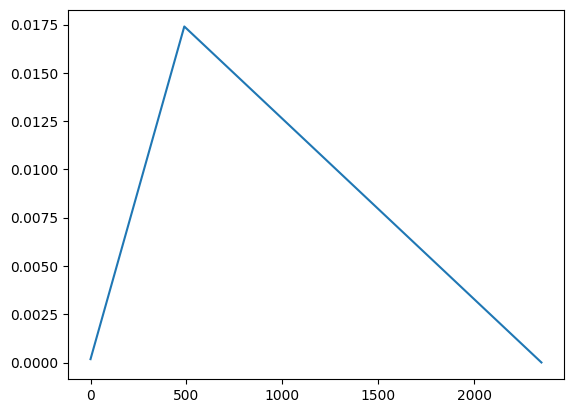

In [10]:
len(lrs)
plt.plot(lrs)

In [ ]:
misclassified_images = misclassified_images.cpu()
misclassified_images_actual_label = misclassified_images_actual_label.cpu()
misclassified_images_predicted_label = misclassified_images_predicted_label.cpu()
for i in range(len(misclassified_images)):
    plt.subplot(3,4,i+1)
    im = misclassified_images[i]
    im = np.transpose(im, axes=[1, 2, 0])
    plt.imshow(im)
    plt.title(inttoclasses[batch_labels[i].item()])
    plt.title('Act: {}/ Pred: {}'.format(inttoclasses[misclassified_images_actual_label[i].item()], inttoclasses[misclassified_images_predicted_label[i].item()]))
    plt.axis('off')

In [ ]:
len(misclassified_images)

In [11]:
model = models.model()
summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,